In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import solve_ivp
import os

In [2]:
def shear_nondim(time, amp, oscillatory):
    if oscillatory:
        return amp * np.sin(time / amp)
    return amp

def shear_rate_nondim(time, amp, oscillatory):
    if oscillatory:
        return np.cos(time / amp)
    return 1

def shear_rate_rate_nondim(time, amp, oscillatory):
    if oscillatory:
        return - (1 / amp) * np.sin(time / amp)
    return 0

In [3]:
def second_inv_nondim(time, amp, oscillatory):
    return np.abs(np.sqrt(2) * shear_rate_nondim(time, amp, oscillatory))

def s_nondim(time, Bi, beta, n, reg, amp, oscillatory):

    second_inv = second_inv_nondim(time, amp, oscillatory)
    yield_stress_term = (Bi / (second_inv + reg))

    if n < 1.0:
        HB_term = (beta * second_inv ** n) / (second_inv + reg)
    else:
        HB_term = beta * (second_inv ** (n - 1))

    return yield_stress_term + HB_term

def relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory):

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    return s + 1

def eta_N_nondim(time, Bi, beta, n, reg, amp, oscillatory):

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    return s / (relaxation_time + reg)

def second_inv_deriv_nondim(time, amp, oscillatory):
    shear_rate = shear_rate_nondim(time, amp, oscillatory)
    shear_rate_rate = shear_rate_rate_nondim(time, amp, oscillatory)

    return np.sqrt(2) * np.sign(shear_rate) * shear_rate_rate

def eta_N_deriv_nondim(time, Bi, beta, n, reg, amp, oscillatory):

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    second_inv = second_inv_nondim(time, amp, oscillatory)
    second_inv_deriv = second_inv_deriv_nondim(time, amp, oscillatory)

    if n < 2:
        return ((1 / (relaxation_time + reg)) - ((1 / (relaxation_time ** 2 + reg)) * s)) * (((-Bi + beta * (n - 1) * second_inv ** n)) / (second_inv ** 2 + reg)) * second_inv_deriv

    return ((1 / (relaxation_time + reg)) - ((1 / (relaxation_time ** 2 + reg)) * s)) * ((-Bi / (second_inv ** 2 + reg)) + (beta * (n - 1) * second_inv ** (n - 2))) * second_inv_deriv

def eta_p_nondim(time, Wi, Bi, beta, n, reg, amp, oscillatory):

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    eta_N = eta_N_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    eta_N_deriv = eta_N_deriv_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    return s - eta_N - Wi * relaxation_time * eta_N_deriv

In [4]:
def ode_rhs_split_nondim(time, tau, reg, oscillatory, Wi, Bi, beta, n, amp):
    txx = tau[0]
    txy = tau[1]

    shear_rate = shear_rate_nondim(time, amp, oscillatory)

    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    eta_p = eta_p_nondim(time, Wi, Bi, beta, n, reg, amp, oscillatory)

    lambda_p = Wi * relaxation_time

    rhs_txx = 2.0 * shear_rate * txy - (txx / (lambda_p + reg))
    rhs_txy = (eta_p * shear_rate - txy) / (lambda_p + reg)

    return np.array( [rhs_txx, rhs_txy])

def ode_rhs_full_nondim(time, tau, reg, oscillatory, Wi, Bi, beta, n, amp):
    txx = tau[0]
    txy = tau[1]

    shear_rate = shear_rate_nondim(time, amp, oscillatory)
    shear_rate_rate = shear_rate_rate_nondim(time, amp, oscillatory)

    s = s_nondim(time, Bi, beta, n, reg, amp, oscillatory)
    relaxation_time = relaxation_time_nondim(time, Bi, beta, n, reg, amp, oscillatory)

    lambda_p = Wi * relaxation_time

    rhs_txx = 2.0 * shear_rate * txy - (txx + 2.0 * s * Wi * shear_rate ** 2) / (lambda_p + reg)
    rhs_txy = (s * (shear_rate + Wi * shear_rate_rate) - txy) / (lambda_p + reg)

    return np.array( [rhs_txx, rhs_txy])


In [5]:
def calculate_params(eta_s, gamma_0, omega, G, tau_y, k, n, decs=3):
    Wi = round((eta_s * gamma_0 * omega) / G, decs)
    Bi = round(tau_y / (eta_s * gamma_0 * omega), decs)
    beta = round((k * (gamma_0 * omega) ** (n - 1)) / eta_s, decs)

    print(f"Wi = {Wi}, Bi = {Bi}, beta = {beta}")
    return Wi, Bi, beta

In [6]:
def plot_dynamic_moduli(Wi, Bi, beta, n, shear_amp_range, eta_s, omega, reg, num_periods, num_amps):

    fig, axs = plt.subplots(1, 2, figsize = (12, 6))
    ax_nondim = axs[0]
    ax_dim = axs[1]

    oscillatory = True

    G_prime_split_nondim_list = []
    G_prime_full_nondim_list = []
    G_prime_split_dim_list = []
    G_prime_full_dim_list = []

    G_prime_prime_split_nondim_list = []
    G_prime_prime_full_nondim_list = []
    G_prime_prime_split_dim_list = []
    G_prime_prime_full_dim_list = []

    sweep_shear_amplitude = np.logspace(shear_amp_range[0], shear_amp_range[1], num=num_amps)
    for i, shear_amp in enumerate(sweep_shear_amplitude):
        
        print(f"\nShear amp: {shear_amp}")
        N_timesteps = 10000

        tMin = 0
        tMax = num_periods * 2.0 * np.pi
        t_eval = np.linspace(tMin, tMax, N_timesteps)

        input_Wi = Wi * shear_amp
        input_Bi = Bi / shear_amp
        input_beta = beta * shear_amp ** (n - 1)

        print(f"Solving for:\tBi = {input_Bi}\tWi = {input_Wi}\tbeta = {input_beta}")

        shear_array = shear_nondim(t_eval, shear_amp, oscillatory)
        shear_rate_array = shear_rate_nondim(t_eval, shear_amp, oscillatory)

        eta_N_array = eta_N_nondim(t_eval, input_Bi, input_beta, n, reg, shear_amp, oscillatory)

        solution_split = solve_ivp(ode_rhs_split_nondim, [0.0, tMax], [0.0, 0.0], t_eval=t_eval, args=([reg, oscillatory, input_Wi, input_Bi, input_beta, n, shear_amp]))
        solution_split_total = solution_split.y[1] + eta_N_array * shear_rate_array

        solution_full = solve_ivp(ode_rhs_full_nondim, [0.0, tMax], [0.0, eta_N_array[0] * shear_rate_array[0]], t_eval=t_eval, args=([reg, oscillatory, input_Wi, input_Bi, input_beta, n, shear_amp]))

        # G'
        G_prime_split_nondim = 2.0 * np.average(shear_array * solution_split_total) / shear_amp
        G_prime_full_nondim = 2.0 * np.average(shear_array * solution_full.y[1]) / shear_amp
        G_prime_split_nondim_list.append(G_prime_split_nondim)
        G_prime_full_nondim_list.append(G_prime_full_nondim)

        # dim_factor_G_prime = 1
        dim_factor_G_prime = eta_s * omega
        G_prime_split_dim = dim_factor_G_prime * G_prime_split_nondim
        G_prime_full_dim = dim_factor_G_prime * G_prime_full_nondim
        G_prime_split_dim_list.append(G_prime_split_dim)
        G_prime_full_dim_list.append(G_prime_full_dim)

        print(f"Obtained:\tG' (split nondim) = {G_prime_split_nondim}\tG' (full nondim) = {G_prime_full_nondim}")
        print(f"Obtained:\tG' (split dim) = {G_prime_split_dim}\tG' (full dim) = {G_prime_full_dim}")

        #G''
        G_prime_prime_split_nondim = 2.0 * np.average(shear_rate_array * solution_split_total)
        G_prime_prime_full_nondim = 2.0 * np.average(shear_rate_array * solution_full.y[1])
        G_prime_prime_split_nondim_list.append(G_prime_prime_split_nondim)
        G_prime_prime_full_nondim_list.append(G_prime_prime_full_nondim)

        # dim_factor_G_prime_prime = 1
        dim_factor_G_prime_prime = eta_s * omega
        G_prime_prime_split_dim = dim_factor_G_prime_prime * G_prime_prime_split_nondim
        G_prime_prime_full_dim = dim_factor_G_prime_prime * G_prime_prime_full_nondim
        G_prime_prime_split_dim_list.append(G_prime_prime_split_dim)
        G_prime_prime_full_dim_list.append(G_prime_prime_full_dim)

        print(f"Obtained:\tG'' (split nondim) = {G_prime_prime_split_nondim}\tG'' (full nondim) = {G_prime_prime_full_nondim}")
        print(f"Obtained:\tG'' (split dim) = {G_prime_prime_split_dim}\tG'' (full dim) = {G_prime_prime_full_dim}")


    ax_nondim.loglog(sweep_shear_amplitude, G_prime_split_nondim_list, "-", color="black", label="G' (split)")
    ax_nondim.loglog(sweep_shear_amplitude, G_prime_full_nondim_list, "--", color="black", label="G' (full)")

    ax_dim.loglog(sweep_shear_amplitude, G_prime_split_dim_list, "-", color="black", label="G' (split)")
    ax_dim.loglog(sweep_shear_amplitude, G_prime_full_dim_list, "--", color="black", label="G' (full)")

    ax_nondim.loglog(sweep_shear_amplitude, G_prime_prime_split_nondim_list, "-", color="red", label="G'' (split)")
    ax_nondim.loglog(sweep_shear_amplitude, G_prime_prime_full_nondim_list, "--", color="red", label="G'' (full)")

    ax_dim.loglog(sweep_shear_amplitude, G_prime_prime_split_dim_list, "-", color="red", label="G'' (split)")
    ax_dim.loglog(sweep_shear_amplitude, G_prime_prime_full_dim_list, "--", color="red", label="G'' (full)")
    
    ax_nondim.legend()
    ax_nondim.set_ylabel("Modulus [-]")
    ax_nondim.set_xlabel("Strain amplitude [-]")
    ax_nondim.set_title("Nondim")

    ax_dim.legend()
    ax_dim.set_ylabel("Modulus [Pa]")
    ax_dim.set_xlabel("Strain amplitude [-]")
    ax_dim.set_title("Dim")

    fig.tight_layout()
    plt.show()

    return G_prime_split_nondim_list, G_prime_full_nondim_list, G_prime_prime_split_nondim_list, G_prime_prime_full_nondim_list

Wi = 0.03, Bi = 7.272, beta = 1.7

Shear amp: 0.001
Solving for:	Bi = 7272.0	Wi = 0.0003	beta = 96.03928571809148
Obtained:	G' (split nondim) = 3.330269684335297	G' (full nondim) = 3.3290471185708084
Obtained:	G' (split dim) = 43.04706593971805	G' (full dim) = 43.031263054646274
Obtained:	G'' (split nondim) = 1.0014840573188144	G'' (full nondim) = 1.0002596740783434
Obtained:	G'' (split dim) = 12.945182924902998	G'' (full dim) = 12.929356547136669

Shear amp: 0.001623776739188721
Solving for:	Bi = 4478.448190872146	Wi = 0.0004871330217566163	beta = 72.36049897540325
Obtained:	G' (split nondim) = 3.3293297569422635	G' (full nondim) = 3.3293597960160906
Obtained:	G' (split dim) = 43.034916438235705	G' (full dim) = 43.035304723303994
Obtained:	G'' (split nondim) = 1.0015094410738608	G'' (full nondim) = 1.0012095759939088
Obtained:	G'' (split dim) = 12.945511035320726	G'' (full dim) = 12.941634979297268

Shear amp: 0.0026366508987303583
Solving for:	Bi = 2758.044306700492	Wi = 0.0007909952

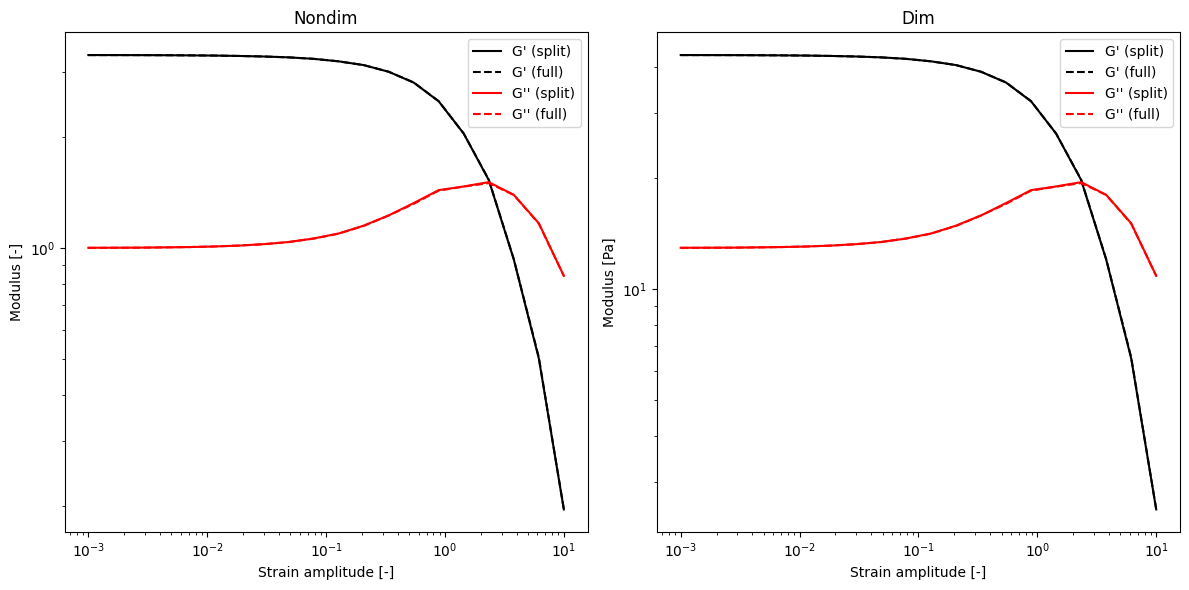

In [7]:
G = 430
eta_s = 23
tau_y = 94
k = 27.93
n = 0.416
gamma_0 = 1
omega = 0.562

Wi, Bi, beta = calculate_params(eta_s, gamma_0, omega, G, tau_y, k, n)

Wi = Wi * 10

oscillatory = True

reg = 1e-3

shear_amp_range=[-3, 1]

num_periods = 10
num_amps = 20

G_prime_split_dim_list, G_prime_full_dim_list, G_prime_prime_split_dim_list, G_prime_prime_full_dim_list = plot_dynamic_moduli(Wi, Bi, beta, n, shear_amp_range, eta_s, omega, reg, num_periods, num_amps)

In [8]:
def create_dynamic_moduli_plots_from_data_new(Wi, Bi, beta, n, Re, reg, oscillatory, shear_amp_list, shear_amp_range, G_prime_list_analytical, G_prime_prime_list_analytical, base_folder, analytical_indicator):

    N_timesteps = 1000
    num_periods = 10

    tMin = 0
    tMax = num_periods * 2.0 * np.pi
    t_eval = np.linspace(tMin, tMax, N_timesteps)

    G_prime_list_data = []
    G_prime_prime_list_data = []

    shear_amp_list_analytical = np.logspace(shear_amp_range[0], shear_amp_range[1], num=20)

    for shear_amp in shear_amp_list:

        # determine parameter values based on shear amp
        input_Wi = round(Wi * shear_amp, 3)
        input_Bi = round(Bi / shear_amp, 3)
        input_beta = round(beta * shear_amp ** (n - 1), 3)

        simulation_folder = "oscillatory_reg%g_Wi%g_Bi%g_beta%g_n%g_Re%g_amp%g_an%g/" % (reg, input_Wi, input_Bi, input_beta, n, Re, shear_amp, analytical_indicator)

        def find_nearest(x):
            difference_array = np.absolute(array_t - x)
            return difference_array.argmin() #returns the index

        file_name = base_folder + simulation_folder + "log_file.txt"
        file_data = np.loadtxt(file_name)
        array_t = file_data[:, 1]
        array_txx = file_data[:, 3]
        array_txy = file_data[:, 4]
        array_tyy = file_data[:, 5]

        selected_indices = np.array( list(map( find_nearest, t_eval )) )
        array_t = array_t[selected_indices]
        array_txx = array_txx[selected_indices]
        array_txy = array_txy[selected_indices]
        array_tyy = array_tyy[selected_indices]

        array_dux_dy = shear_rate_nondim(array_t, shear_amp, oscillatory)
        array_txy = array_txy + eta_N_nondim(array_t, input_Bi, input_beta, n, reg, shear_amp, oscillatory) * array_dux_dy
        
        shear_array_data = shear_nondim(array_t, shear_amp, oscillatory)

        start_index = 0

        array_t = array_t[start_index:]
        array_txx = array_txx[start_index:]
        array_txy = array_txy[start_index:]
        array_dux_dy = array_dux_dy[start_index:]
        shear_array_data = shear_array_data[start_index:]

        shear_times_stress_data = shear_array_data * array_txy
        G_prime_data = (2 * np.average(shear_times_stress_data)) / (shear_amp)

        shear_rate_times_stress_data = array_dux_dy * array_txy
        G_prime_prime_data = (2 * np.average(shear_rate_times_stress_data))

        G_prime_list_data.append(G_prime_data)
        G_prime_prime_list_data.append(G_prime_prime_data)

    fig, axs = plt.subplots(1, 1, figsize = (6,6))
    ax_G = axs

    ax_G.loglog(shear_amp_list_analytical, G_prime_list_analytical, "-", color="k", label="G' analytical")
    ax_G.loglog(shear_amp_list_analytical, G_prime_prime_list_analytical, "--", color="k", label="G'' analytical")
    ax_G.plot(shear_amp_list, G_prime_list_data, 's', label = "G' Basilisk", color = 'k', fillstyle = 'none', markersize=10)
    ax_G.plot(shear_amp_list, G_prime_prime_list_data, 'o', label = "G'' Basilisk", color = 'k', fillstyle = 'none', markersize=10)

    ax_G.legend(ncol=2, prop={'size': 15})
    ax_G.set_ylabel(r"Modulus [-]")
    ax_G.set_xlabel(r"Strain amplitude $\gamma_0$ [-]")

    fig.tight_layout()
    plt.show()

Wi = 0.03, Bi = 7.272, beta = 1.7


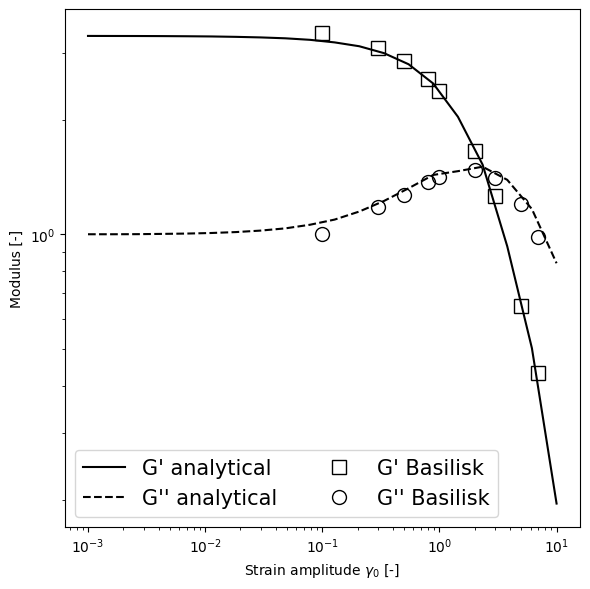

In [9]:
G = 430
eta_s = 23
tau_y = 94
k = 27.93
n = 0.416
gamma_0 = 1
omega = 0.562

Wi, Bi, beta = calculate_params(eta_s, gamma_0, omega, G, tau_y, k, n)

Wi = Wi * 10

Re = 0.1
reg = 1e-3
oscillatory = True
analytical_indicator = 1

shear_amp_range=[-3, 1]
shear_amp_list = [0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0, 7.0]

G_prime_list_analytical = G_prime_split_dim_list
G_prime_prime_list_analytical = G_prime_prime_split_dim_list

base_folder = os.path.curdir + "/outputs/Dynamic moduli plot final/"

create_dynamic_moduli_plots_from_data_new(Wi, Bi, beta, n, Re, reg, oscillatory, shear_amp_list, shear_amp_range, G_prime_list_analytical, G_prime_prime_list_analytical, base_folder, analytical_indicator)